In [1]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import windows, freqz
from phw_lib import *

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import tensorflow as tf

DL_model_raw = tf.keras.models.load_model('../phasor_walkout_DL_classification_model.h5')
DL_model_bandpass = tf.keras.models.load_model('../phasor_walkout_DL_classification_model_bandpass.h5')
DL_model_PAC = tf.keras.models.load_model('../phasor_walkout_DL_classification_model_PAC.h5')

def get_DL_prob(xi, dt, f_target, model):
    phasors, _ = phasor_walkout(xi, dt, f_target)
    cumulative_sums = np.cumsum(phasors)
    input_length = len(cumulative_sums)
    input_data = np.zeros((1, input_length, 4))
    input_data[0, :, 0] = phasors.real
    input_data[0, :, 1] = phasors.imag
    input_data[0, :, 2] = cumulative_sums.real
    input_data[0, :, 3] = cumulative_sums.imag
    # normalize the input data
    # normalize the input
    input_data[0, :, :] = input_data[0, :, :]/np.max(np.abs(input_data[0, :, :]))
    # predict the probability
    prob = model.predict(input_data)[0]
    return prob

2025-07-08 13:04:40.930688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 13:04:41.919391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:ce:00.0, compute capability: 8.6


In [2]:
event_dict = {}

event_dict['M6.5_VANUATU_ISLANDS_20140101'] = dict()
event_dict['M6.5_VANUATU_ISLANDS_20140101']['time'] = '2014-01-01T16:03:29.770000Z'
event_dict['M6.5_VANUATU_ISLANDS_20140101']['name'] = 'M6.5_VANUATU_20140101'

event_dict['M6.6_NORTH_OF_ASCENSION_ISLAND_20170818'] = dict()
event_dict['M6.6_NORTH_OF_ASCENSION_ISLAND_20170818']['time'] = '2017-08-18T02:59:21.950000Z'
event_dict['M6.6_NORTH_OF_ASCENSION_ISLAND_20170818']['name'] = 'M6.6_ASCENSION_20170818'

event_dict['M7.2_OAXACA_MEXICO_20180216'] = dict()
event_dict['M7.2_OAXACA_MEXICO_20180216']['time'] = '2018-02-16T23:39:39.700000Z'
event_dict['M7.2_OAXACA_MEXICO_20180216']['name'] = 'M7.2_OAXACA_20180216'

event_dict['M7.5_SOUTHEASTERN_ALASKA_20130105'] = dict()
event_dict['M7.5_SOUTHEASTERN_ALASKA_20130105']['time'] = '2013-01-05T08:58:19.180000Z'
event_dict['M7.5_SOUTHEASTERN_ALASKA_20130105']['name'] = 'M7.5_ALASKA_20130105'

event_dict['M8.1_EAST_OF_KURIL_ISLANDS_20070113'] = dict()
event_dict['M8.1_EAST_OF_KURIL_ISLANDS_20070113']['time'] = '2007-01-13T04:23:23.250000Z'
event_dict['M8.1_EAST_OF_KURIL_ISLANDS_20070113']['name'] = 'M8.1_KURIL_20070113'

event_dict['M8.1_NEAR_COAST_OF_CHIAPAS_MEXICO_20170908'] = dict()
event_dict['M8.1_NEAR_COAST_OF_CHIAPAS_MEXICO_20170908']['time'] = '2017-09-08T04:49:20.000000Z'
event_dict['M8.1_NEAR_COAST_OF_CHIAPAS_MEXICO_20170908']['name'] = 'M8.1_CHIAPAS_20170908'

event_dict['JP_M9.1'] = dict()
event_dict['JP_M9.1']['time'] = '2011-03-11T05:46:24'
event_dict['JP_M9.1']['name'] = 'M9.1_TOHOKU_20110311'

In [4]:
power_spectrum_dict = {}

eval_keys = list(event_dict.keys())

# 'hann' or 'mulitaper_sinsoidal'
window_choice = 'hann'

res_dict = dict()

test_time_length_in_sec = 86400*3

# -1 stands for all peaks
peak_num = -1

for key in eval_keys:
    net = 'G'
    sta = 'CAN'
    event_name = key
    res_dict[key] = dict()
    res_dict[key]['After'] = dict()
    res_dict[key]['Before'] = dict()
    for after_before in ['After', 'Before']:
        res_dict[key][after_before]['R2'] = []
        res_dict[key][after_before]['SS'] =  []
        res_dict[key][after_before]['SS_mag'] =  []
        res_dict[key][after_before]['CIPSR'] = []
        res_dict[key][after_before]['DL'] = []
        res_dict[key][after_before]['freq'] = []

    print('On event: {} Time Length: {}'.format(key, test_time_length_in_sec))
    st = obspy.read('./pwr_realworld_no_near_earthquakes/{}/{}.{}.After.mseed'.format(event_name, net, sta))
    print(st[0].stats.starttime - obspy.UTCDateTime(event_dict[key]['time']))
    print(st[0].stats.endtime - st[0].stats.starttime)
    # select BHZ channel
    st_bhz = st.select(channel='BHZ')
    st_bhz.trim(st_bhz[0].stats.starttime, st_bhz[0].stats.starttime + test_time_length_in_sec)
    
    # resampe to 0.5 Hz
    st_bhz.resample(0.5, window='hann')

    # demean delinear trend remove response
    st_bhz.detrend('linear')
    st_bhz.detrend('demean')

    # fft transform
    npts = st_bhz[0].stats.npts
    dt = st_bhz[0].stats.delta
    f = np.fft.rfftfreq(npts, dt)

    ori_data = st_bhz[0].data.copy()
    
    if window_choice == 'hann':
        windowed_data = ori_data * np.hanning(npts)
        Y = np.fft.rfft(windowed_data)
        Y_abs = np.abs(Y)**2
    else:
        Y = np.fft.rfft(ori_data)
        Y_abs = np.abs(Y)**2
        
    min_freq = 1*1e-4
    max_freq = 10*1e-3

    fs = 1/dt
    time_duration = st[0].stats.endtime - st[0].stats.starttime
    n_samples = int(time_duration/dt)
    t = np.arange(0, time_duration, dt)
    freqs = np.fft.fftfreq(len(t), dt)

    search_lower_range = min_freq
    search_upper_range = max_freq

    lower_freq = min_freq
    upper_freq = max_freq

    min_freq_index = np.argmin(np.abs(f - min_freq))
    max_freq_index = np.argmin(np.abs(f - max_freq))

    fft_amp = Y_abs

    peaks, _ = find_peaks(fft_amp, distance=1)

    peaks = peaks[np.logical_and(f[peaks] > search_lower_range, f[peaks] < search_upper_range)]
    peaks = peaks[np.argsort(fft_amp[peaks])][::-1][:peak_num]
    # sort for top 100 peaks
    for t_peak in peaks:
        target_freq = f[t_peak]
        R = calculate_walkout_R2(ori_data, dt, target_freq)
        sum_ratio = linearity_measure_by_sum_ratio(ori_data, dt, target_freq)
        schuster_significance, ss_mag = schuster_test_for_phasor_walkout(ori_data, dt, target_freq)
        res_dict[key]['After']['R2'].append(R)
        res_dict[key]['After']['SS'].append(schuster_significance)
        res_dict[key]['After']['SS_mag'].append(ss_mag)
        res_dict[key]['After']['CIPSR'].append(sum_ratio)
        res_dict[key]['After']['DL'].append(get_DL_prob(ori_data, dt, target_freq, DL_model_raw))
        res_dict[key]['After']['freq'].append(target_freq)

    st = obspy.read('./pwr_realworld_no_near_earthquakes/{}/{}.{}.Before.mseed'.format(event_name, net, sta))
    print(st[0].stats.starttime)
    print(st[0].stats.endtime)
    print( obspy.UTCDateTime(event_dict[key]['time']))
    # select BHZ channel
    st_bhz = st.select(channel='BHZ')
    st_bhz.trim(st_bhz[0].stats.endtime - test_time_length_in_sec, st_bhz[0].stats.endtime)
    print(st[0].stats.endtime - obspy.UTCDateTime(event_dict[key]['time']))
    print(st[0].stats.endtime - st[0].stats.starttime)
    # resampe to 0.5 Hz
    st_bhz.resample(0.5, window='hann')

    # demean delinear trend remove response
    st_bhz.detrend('linear')
    st_bhz.detrend('demean')

    # fft transform
    npts = st_bhz[0].stats.npts
    dt = st_bhz[0].stats.delta
    f = np.fft.rfftfreq(npts, dt)

    ori_data = st_bhz[0].data.copy()

    if window_choice == 'hann':
        windowed_data = ori_data * np.hanning(npts)
        Y = np.fft.rfft(windowed_data)
        Y_abs = np.abs(Y)**2
    else:
        Y = np.fft.rfft(ori_data)
        Y_abs = np.abs(Y)**2

    min_freq = 1*1e-4
    max_freq = 10*1e-3

    fs = 1/dt
    time_duration = st[0].stats.endtime - st[0].stats.starttime
    n_samples = int(time_duration/dt)
    t = np.arange(0, time_duration, dt)
    freqs = np.fft.fftfreq(len(t), dt)

    search_lower_range = min_freq
    search_upper_range = max_freq

    lower_freq = min_freq
    upper_freq = max_freq
    
    min_freq_index = np.argmin(np.abs(f - min_freq))
    max_freq_index = np.argmin(np.abs(f - max_freq))

    fft_amp = Y_abs

    peaks, _ = find_peaks(fft_amp, distance=1)

    peaks = peaks[np.logical_and(f[peaks] > search_lower_range, f[peaks] < search_upper_range)]
    peaks = peaks[np.argsort(fft_amp[peaks])][::-1][:peak_num]
    # sort for top 100 peaks

    for t_peak in peaks:
        target_freq = f[t_peak]
        R = calculate_walkout_R2(ori_data, dt, target_freq)
        sum_ratio = linearity_measure_by_sum_ratio(ori_data, dt, target_freq)
        schuster_significance, ss_mag = schuster_test_for_phasor_walkout(ori_data, dt, target_freq)
        res_dict[key]['Before']['R2'].append(R)
        res_dict[key]['Before']['SS'].append(schuster_significance)
        res_dict[key]['Before']['SS_mag'].append(ss_mag)
        res_dict[key]['Before']['CIPSR'].append(sum_ratio)
        res_dict[key]['Before']['DL'].append(get_DL_prob(ori_data, dt, target_freq, DL_model_raw))
        res_dict[key]['Before']['freq'].append(target_freq)

On event: M6.5_VANUATU_ISLANDS_20140101 Time Length: 259200
0.049538
345599.95


2025-07-08 13:05:02.121253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-07-08 13:05:04.084495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401


2013-12-28T16:03:29.819538Z
2014-01-01T16:03:29.769538Z
2014-01-01T16:03:29.770000Z
-0.000462
259200.0
On event: M6.6_NORTH_OF_ASCENSION_ISLAND_20170818 Time Length: 259200
0.0
691200.0
2017-08-10T02:59:21.950000Z
2017-08-18T02:59:21.950000Z
2017-08-18T02:59:21.950000Z
0.0
691200.0
On event: M7.2_OAXACA_MEXICO_20180216 Time Length: 259200
0.0
474589.35


In [ ]:
np.save('res_dict_for_Figure10.npy', res_dict)

In [3]:
res_dict = np.load('./res_dict_for_Figure10.npy', allow_pickle=True)[()]

['M6.5_VANUATU_ISLANDS_20140101', 'M6.6_NORTH_OF_ASCENSION_ISLAND_20170818', 'M7.2_OAXACA_MEXICO_20180216', 'M7.5_SOUTHEASTERN_ALASKA_20130105', 'M8.1_EAST_OF_KURIL_ISLANDS_20070113', 'M8.1_NEAR_COAST_OF_CHIAPAS_MEXICO_20170908', 'JP_M9.1']
0
1
2
3
4
5
6


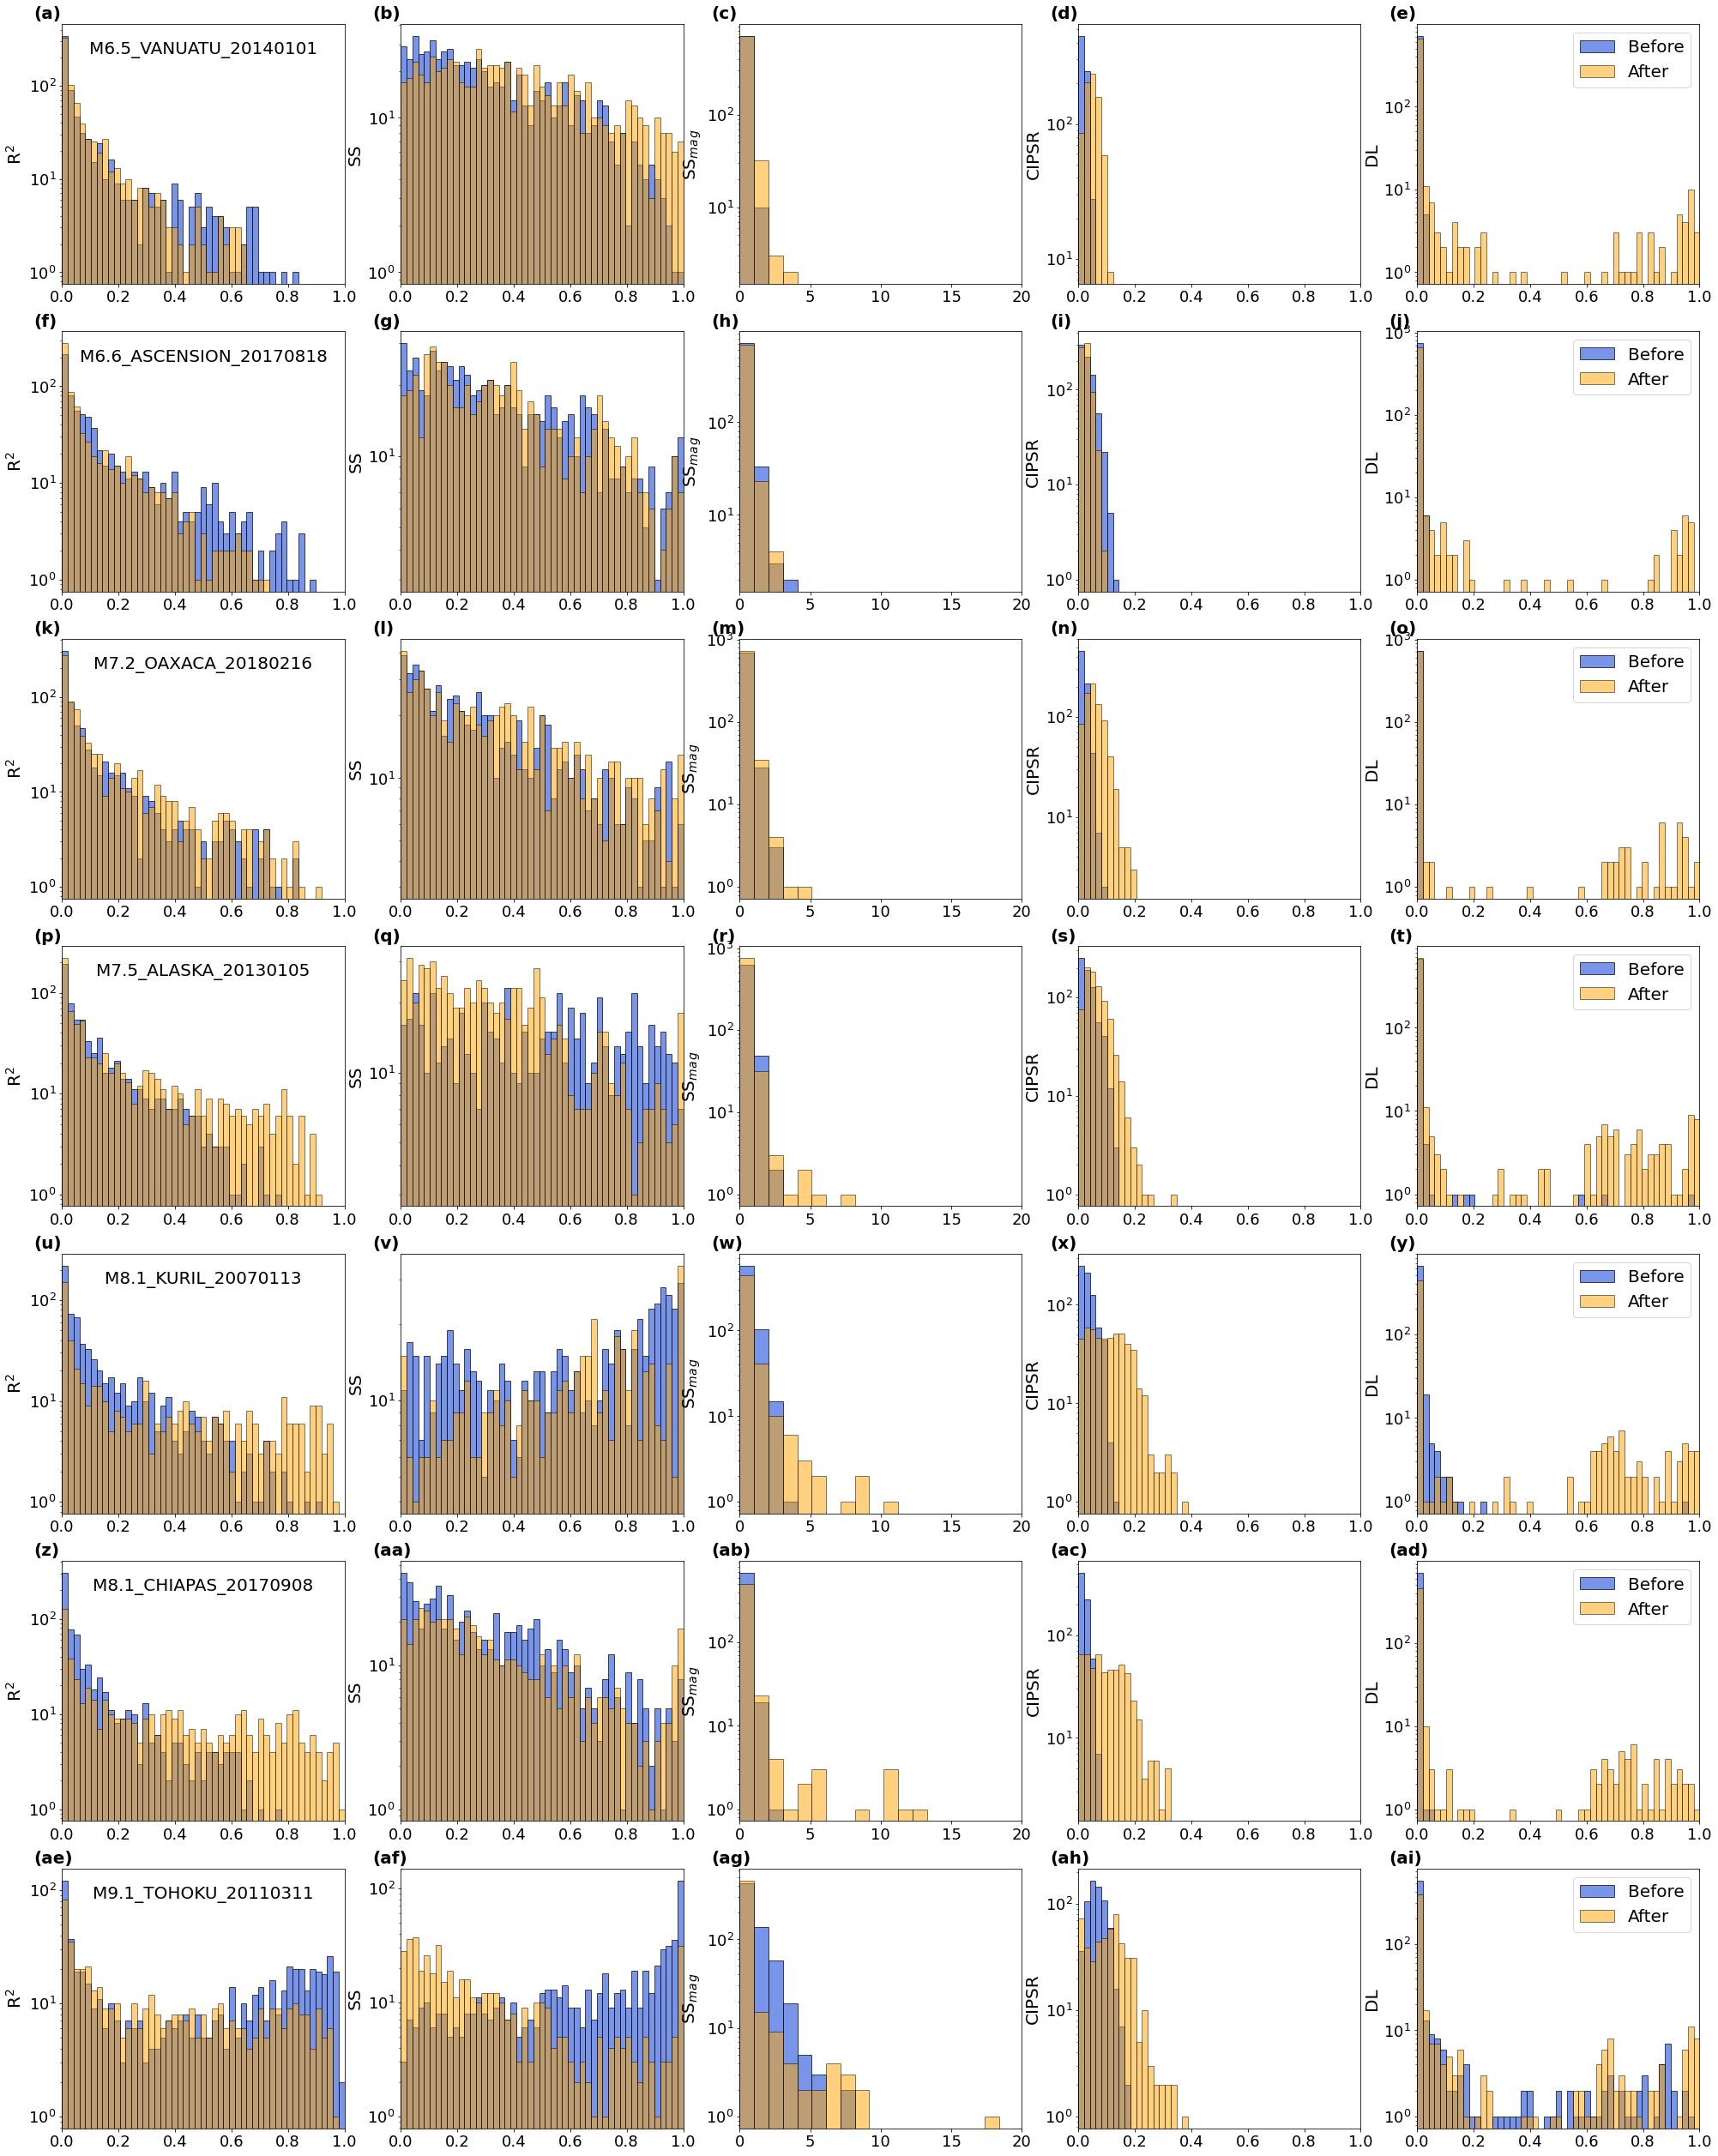

In [4]:
eval_keys = list(event_dict.keys())
print(eval_keys)
total_num = len(eval_keys)
fig, ax = plt.subplots(total_num, 5, figsize=(28, 5*total_num))

# plot the results using histogram
for idx, key in enumerate(eval_keys):
    print(idx)
    bins_for_R2 = np.linspace(0, 1, 50)
    bins_for_SS = np.linspace(0, 1, 50)
    #bins_for_SS = np.linspace(0, 1, 50)
    bins_for_CIPSR = np.linspace(0, 1, 50)
    bins_for_SS_mag = np.linspace(0, 50, 50)


    ax[idx, 0].hist(res_dict[key]['Before']['R2'], bins=bins_for_R2, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    plt.sca(ax[idx, 0])
    if idx == 0:
        plt.text(-0.10, 1.02, '(a)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 1:
        plt.text(-0.10, 1.02, '(f)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 2:
        plt.text(-0.10, 1.02, '(k)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 3:
        plt.text(-0.10, 1.02, '(p)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 4:
        plt.text(-0.10, 1.02, '(u)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 5:
        plt.text(-0.10, 1.02, '(z)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 6:
        plt.text(-0.10, 1.02, '(ae)', transform=plt.gca().transAxes, size=20, weight='bold')

    ax[idx, 1].hist(res_dict[key]['Before']['SS'], bins=bins_for_SS, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    plt.sca(ax[idx, 1])
    if idx == 0:
        plt.text(-0.10, 1.02, '(b)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 1:
        plt.text(-0.10, 1.02, '(g)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 2:
        plt.text(-0.10, 1.02, '(l)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 3:
        plt.text(-0.10, 1.02, '(q)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 4:
        plt.text(-0.10, 1.02, '(v)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 5:
        plt.text(-0.10, 1.02, '(aa)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 6:
        plt.text(-0.10, 1.02, '(af)', transform=plt.gca().transAxes, size=20, weight='bold')

    ax[idx, 2].hist(res_dict[key]['Before']['SS_mag'], bins=bins_for_SS_mag, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    plt.sca(ax[idx, 2])
    if idx == 0:
        plt.text(-0.10, 1.02, '(c)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 1:
        plt.text(-0.10, 1.02, '(h)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 2:
        plt.text(-0.10, 1.02, '(m)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 3:
        plt.text(-0.10, 1.02, '(r)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 4:
        plt.text(-0.10, 1.02, '(w)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 5:
        plt.text(-0.10, 1.02, '(ab)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 6:
        plt.text(-0.10, 1.02, '(ag)', transform=plt.gca().transAxes, size=20, weight='bold')
    
    ax[idx, 3].hist(res_dict[key]['Before']['CIPSR'], bins=bins_for_CIPSR, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    plt.sca(ax[idx, 3])
    if idx == 0:
        plt.text(-0.10, 1.02, '(d)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 1:
        plt.text(-0.10, 1.02, '(i)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 2:
        plt.text(-0.10, 1.02, '(n)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 3:
        plt.text(-0.10, 1.02, '(s)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 4:
        plt.text(-0.10, 1.02, '(x)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 5:
        plt.text(-0.10, 1.02, '(ac)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 6:
        plt.text(-0.10, 1.02, '(ah)', transform=plt.gca().transAxes, size=20, weight='bold')
    
    ax[idx, 4].hist(np.asarray(res_dict[key]['Before']['DL'])[:, 0], bins=np.linspace(0, 1, 50), alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    plt.sca(ax[idx, 4])
    if idx == 0:
        plt.text(-0.10, 1.02, '(e)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 1:
        plt.text(-0.10, 1.02, '(j)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 2:
        plt.text(-0.10, 1.02, '(o)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 3:
        plt.text(-0.10, 1.02, '(t)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 4:
        plt.text(-0.10, 1.02, '(y)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 5:
        plt.text(-0.10, 1.02, '(ad)', transform=plt.gca().transAxes, size=20, weight='bold')
    elif idx == 6:
        plt.text(-0.10, 1.02, '(ai)', transform=plt.gca().transAxes, size=20, weight='bold')
    
    ax[idx, 0].hist(res_dict[key]['After']['R2'], bins=bins_for_R2, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 1].hist(res_dict[key]['After']['SS'], bins=bins_for_SS, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 2].hist(res_dict[key]['After']['SS_mag'], bins=bins_for_SS_mag, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 3].hist(res_dict[key]['After']['CIPSR'], bins=bins_for_CIPSR, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 4].hist(np.asarray(res_dict[key]['After']['DL'])[:, 0], bins=np.linspace(0, 1, 50), alpha=0.5, label='After', color = 'orange', edgecolor='black')

    # R$^2$: {:.3f}\nSS: {:.3f}\nSS$_m$$_a$$_g$:
    ax[idx, 0].set_ylabel('R$^2$', fontsize=20)
    
    ax[idx, 4].legend(loc='upper right', fontsize=20)
    
    ax[idx, 1].set_ylabel('SS', fontsize=20)
    ax[idx, 2].set_ylabel('SS$_m$$_a$$_g$', fontsize=20)
    ax[idx, 3].set_ylabel('CIPSR', fontsize=20)
    ax[idx, 4].set_ylabel('DL', fontsize=20)

    # set ticks font size to be 14
    ax[idx, 0].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 1].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 2].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 3].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 4].tick_params(axis='both', which='major', labelsize=18)

    #ax[idx, 0].set_title('{}'.format(event_dict[key]['name']), fontsize=14)
    ax[idx, 0].text(0.5, 0.90, '{}'.format(event_dict[key]['name']), horizontalalignment='center', verticalalignment='center', transform=ax[idx, 0].transAxes, fontsize=20)
    # log scale for y
    ax[idx, 0].set_yscale('log')
    ax[idx, 1].set_yscale('log')
    ax[idx, 2].set_yscale('log')
    ax[idx, 3].set_yscale('log')
    ax[idx, 4].set_yscale('log')

    # set x lim
    ax[idx, 0].set_xlim([0, 1])
    ax[idx, 1].set_xlim([0, 1])
    ax[idx, 2].set_xlim([0, 20])
    ax[idx, 3].set_xlim([0, 1])
    ax[idx, 4].set_xlim([0, 1])
    #ax[idx, 0].set_ylabel(key, fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('Figure10.jpg', dpi=600)
plt.show()
plt.close()

In [16]:
np.shape(np.asarray(res_dict[key]['Before']['DL'])[:, 0])

(724,)

['M6.5_VANUATU_ISLANDS_20140101', 'M6.6_NORTH_OF_ASCENSION_ISLAND_20170818', 'M7.2_OAXACA_MEXICO_20180216', 'M7.5_SOUTHEASTERN_ALASKA_20130105', 'M8.1_EAST_OF_KURIL_ISLANDS_20070113', 'M8.1_NEAR_COAST_OF_CHIAPAS_MEXICO_20170908', 'JP_M9.1']


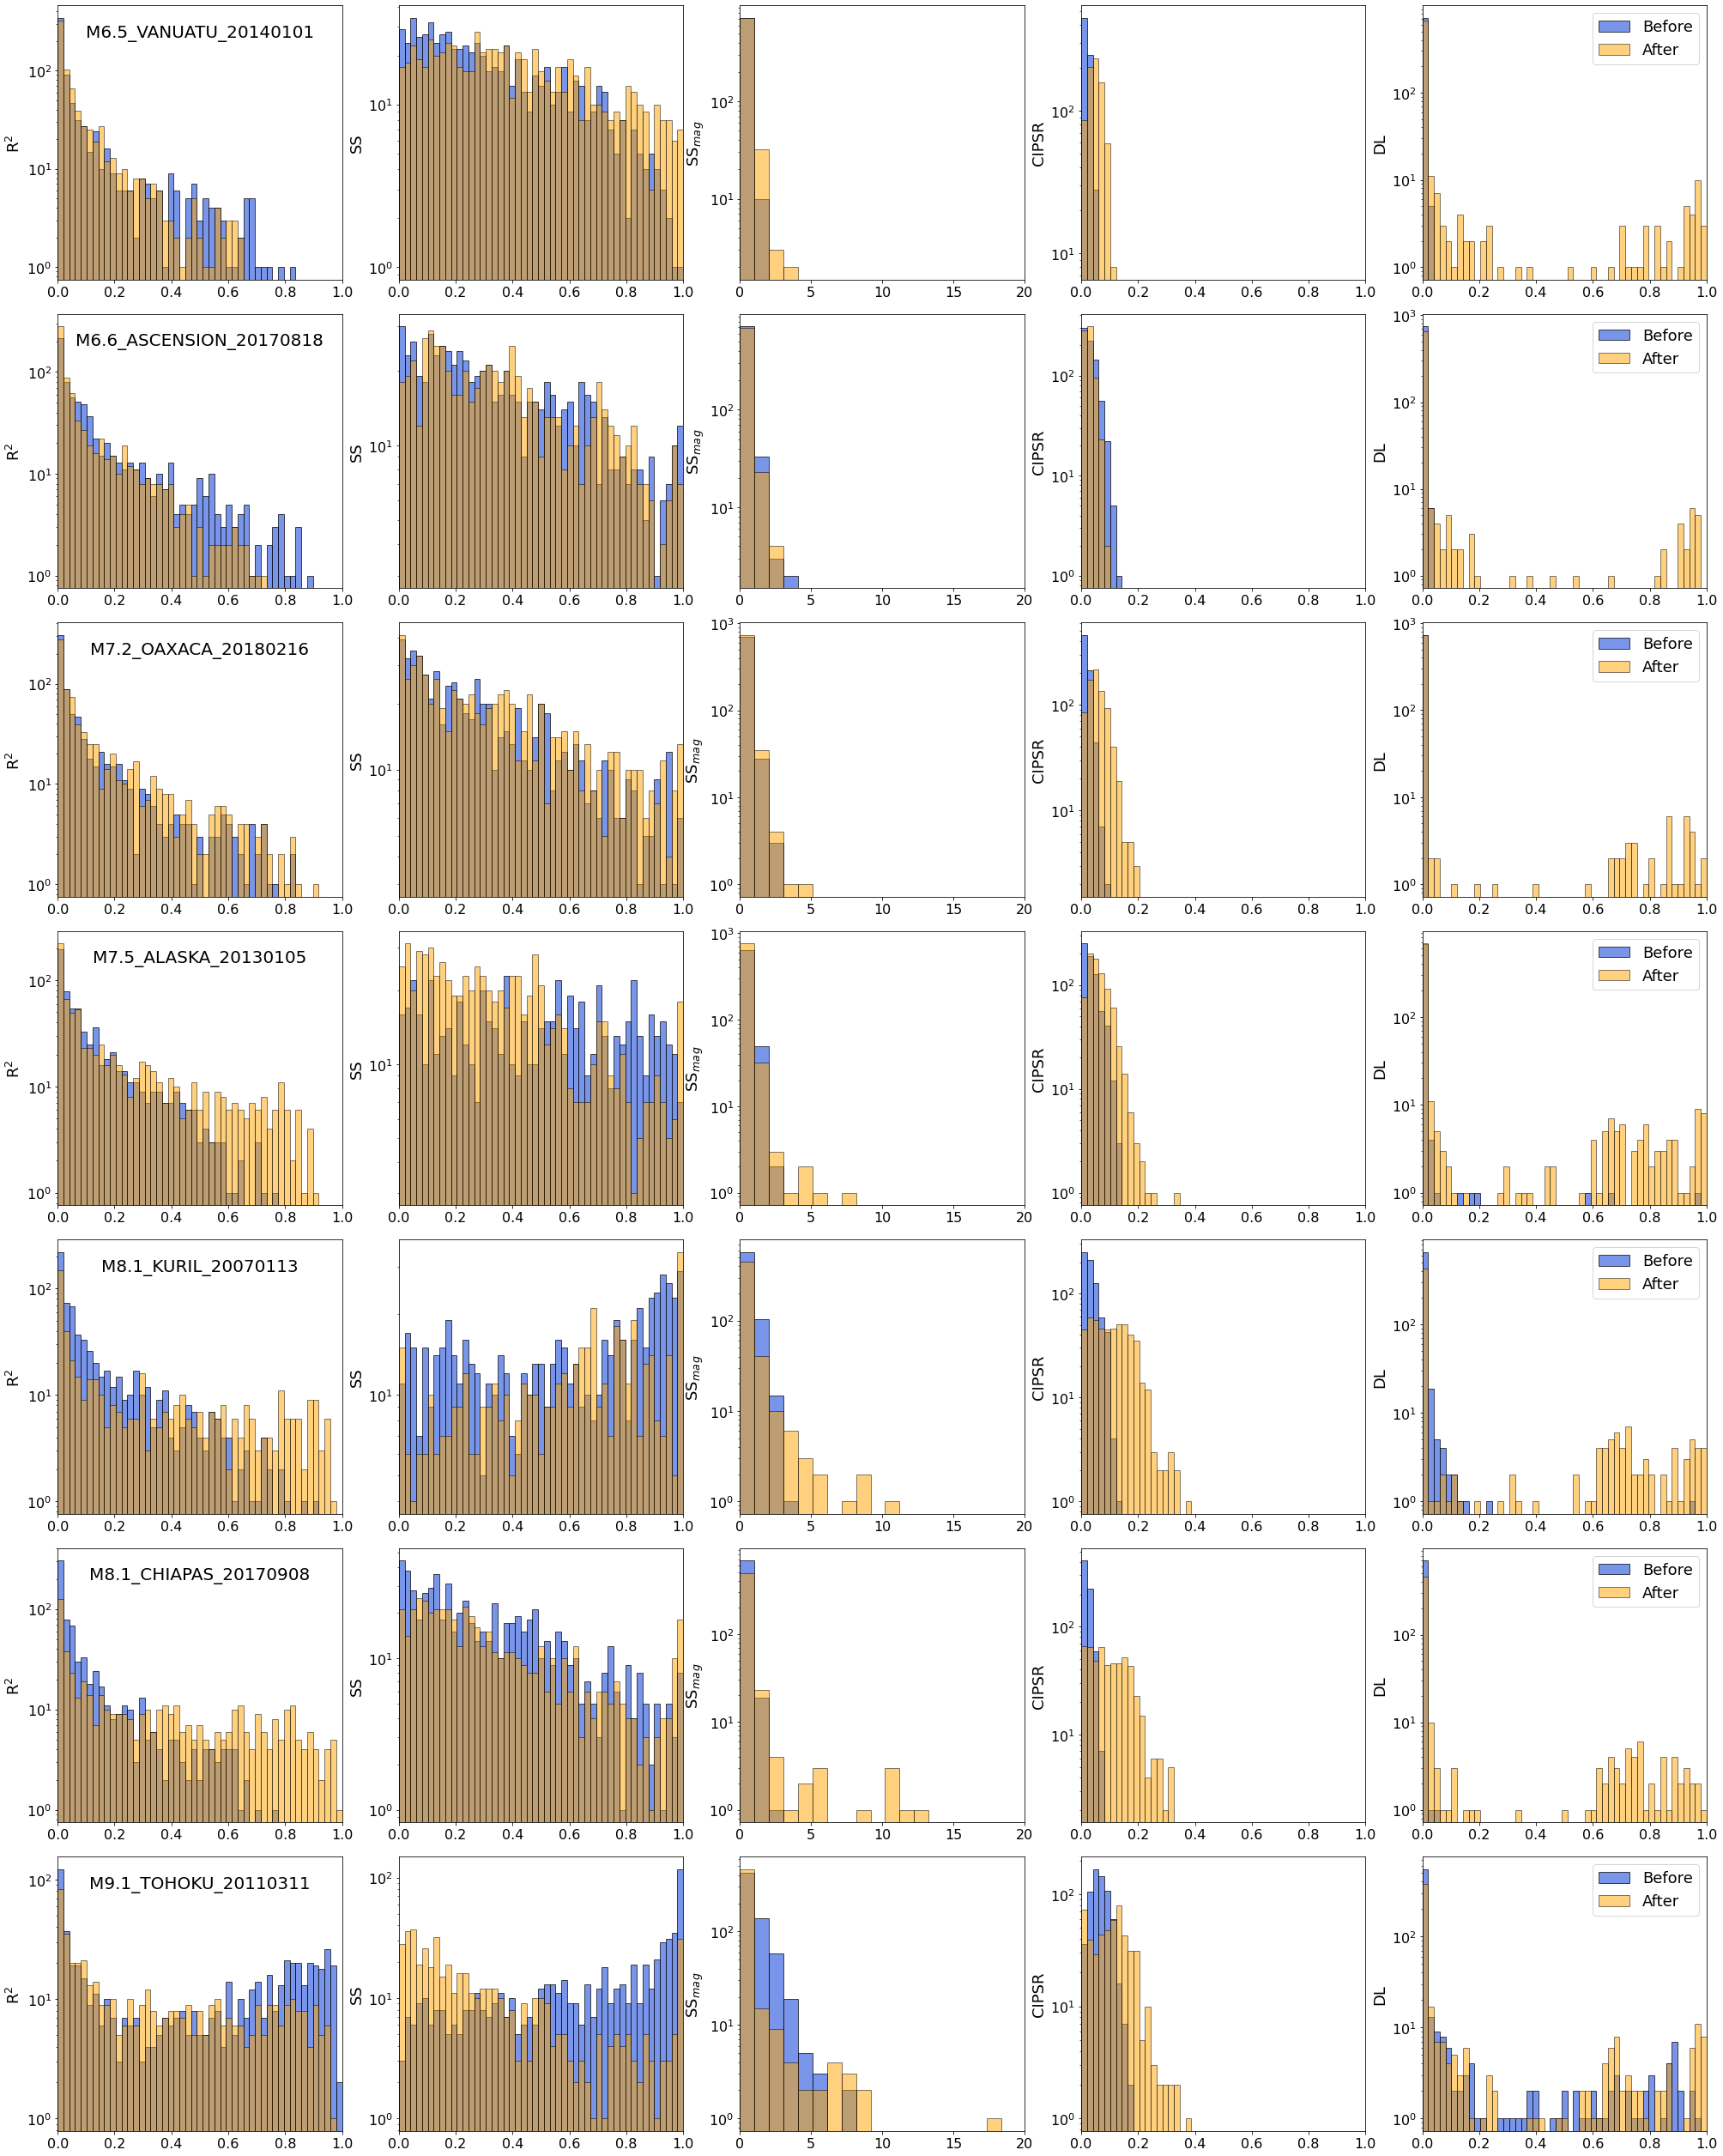

In [5]:
eval_keys = list(event_dict.keys())
print(eval_keys)
total_num = len(eval_keys)
fig, ax = plt.subplots(total_num, 5, figsize=(28, 5*total_num))

# plot the results using histogram
for idx, key in enumerate(eval_keys):
    bins_for_R2 = np.linspace(0, 1, 50)
    bins_for_SS = np.linspace(0, 1, 50)
    #bins_for_SS = np.linspace(0, 1, 50)
    bins_for_CIPSR = np.linspace(0, 1, 50)
    bins_for_SS_mag = np.linspace(0, 50, 50)


    ax[idx, 0].hist(res_dict[key]['Before']['R2'], bins=bins_for_R2, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    
    ax[idx, 1].hist(res_dict[key]['Before']['SS'], bins=bins_for_SS, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    
    ax[idx, 2].hist(res_dict[key]['Before']['SS_mag'], bins=bins_for_SS_mag, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    
    ax[idx, 3].hist(res_dict[key]['Before']['CIPSR'], bins=bins_for_CIPSR, alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    
    ax[idx, 4].hist(np.asarray(res_dict[key]['Before']['DL'])[:, 0], bins=np.linspace(0, 1, 50), alpha=0.7, label='Before', color = 'royalblue', edgecolor='black')
    
    ax[idx, 0].hist(res_dict[key]['After']['R2'], bins=bins_for_R2, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 1].hist(res_dict[key]['After']['SS'], bins=bins_for_SS, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 2].hist(res_dict[key]['After']['SS_mag'], bins=bins_for_SS_mag, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 3].hist(res_dict[key]['After']['CIPSR'], bins=bins_for_CIPSR, alpha=0.5, label='After', color = 'orange', edgecolor='black')
    ax[idx, 4].hist(np.asarray(res_dict[key]['After']['DL'])[:, 0], bins=np.linspace(0, 1, 50), alpha=0.5, label='After', color = 'orange', edgecolor='black')

    # R$^2$: {:.3f}\nSS: {:.3f}\nSS$_m$$_a$$_g$:
    ax[idx, 0].set_ylabel('R$^2$', fontsize=20)
    
    ax[idx, 4].legend(loc='upper right', fontsize=20)
    
    ax[idx, 1].set_ylabel('SS', fontsize=20)
    ax[idx, 2].set_ylabel('SS$_m$$_a$$_g$', fontsize=20)
    ax[idx, 3].set_ylabel('CIPSR', fontsize=20)
    ax[idx, 4].set_ylabel('DL', fontsize=20)

    # set ticks font size to be 14
    ax[idx, 0].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 1].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 2].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 3].tick_params(axis='both', which='major', labelsize=18)
    ax[idx, 4].tick_params(axis='both', which='major', labelsize=18)

    #ax[idx, 0].set_title('{}'.format(event_dict[key]['name']), fontsize=14)
    ax[idx, 0].text(0.5, 0.90, '{}'.format(event_dict[key]['name']), horizontalalignment='center', verticalalignment='center', transform=ax[idx, 0].transAxes, fontsize=20)
    # log scale for y
    ax[idx, 0].set_yscale('log')
    ax[idx, 1].set_yscale('log')
    ax[idx, 2].set_yscale('log')
    ax[idx, 3].set_yscale('log')
    ax[idx, 4].set_yscale('log')

    # set x lim
    ax[idx, 0].set_xlim([0, 1])
    ax[idx, 1].set_xlim([0, 1])
    ax[idx, 2].set_xlim([0, 20])
    ax[idx, 3].set_xlim([0, 1])
    ax[idx, 4].set_xlim([0, 1])
    #ax[idx, 0].set_ylabel(key, fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('Figure10.jpg', dpi=600)
plt.show()
plt.close()